# Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

torch.manual_seed(42)

d:\data_science\python\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\data_science\python\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
d:\data_science\python\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Model Definition

We are using a 4 layered MLP that takes in the coordinates as input and try to approximate underlying patterns in the coordinates

In [2]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(17, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 17)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Custom Dataloader

In [3]:
class Dataset_feeder(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_data, label_data = self.data[idx]
        # Converting input and label from array to Tensor
        input_data = torch.tensor(input_data, dtype=torch.float32)
        label_data = torch.tensor(label_data, dtype=torch.float32)
        return input_data, label_data

In [5]:
# Training data for the MLP
coords = pd.read_csv(".\\OpenPose_base\\train_coords.csv")
print("Shape of the Dataset:", coords.shape)

# Since the CSV has list of coordinates as strings
# we use ast.literal_eval to convert it back to list
input_data = [(ast.literal_eval(coords.iloc[i]['pred_x']), 
               ast.literal_eval(coords.iloc[i]['true_x'])) 
              for i in range(coords.shape[0])]

# Feeding data to the data generator function
dataset = Dataset_feeder(input_data)

# Loading the dataloader with the dataset
# Batch size 12 to exactly be a factor of the number of samples in train
dataloader = DataLoader(dataset, batch_size=12, shuffle=False)

Shape of the Dataset: (1236, 4)


# Model for X Coordinates

In [5]:
# Detecting which device to run the model on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiating MLP
model_x = MLP()

# Transferring the model to GPU
model_x.to(device)

# Criterion
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.SGD(model_x.parameters(), lr=0.0001)

In [6]:
# Store loss values
loss_vals_x = []

# training loop
for epoch in range(2000):
    # Optimizer grad set to 0
    optimizer.zero_grad()
    for inputs, labels in dataloader:
        # Inputs and Labels sent to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Get output from model
        outputs = model_x(inputs)
        
        # Loss calculation
        loss = criterion(outputs, labels)
        
        # Propagate Loss
        loss.backward()
        
        # Optimizer step execution
        optimizer.step()
    if epoch % 100 == 0:
        loss_vals_x.append(loss.item())
        
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: loss={loss.item()}")

Epoch 0: loss=2039.487060546875
Epoch 1000: loss=188.08840942382812


# Model for Y coordinates

In [9]:
# Detecting which device to run the model on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiating MLP
model_y = MLP()

# Transferring the model to GPU
model_y.to(device)

# Criterion
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.SGD(model_y.parameters(), lr=0.0001)

In [10]:
# Store loss values
loss_vals_y = []

# training loop
for epoch in range(2000):
    # Optimizer grad set to 0
    optimizer.zero_grad()
    for inputs, labels in dataloader:
        # Inputs and Labels sent to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Get output from model
        outputs = model_y(inputs)
        
        # Loss calculation
        loss = criterion(outputs, labels)
        
        # Propagate Loss
        loss.backward()
        
        # Optimizer step execution
        optimizer.step()
    if epoch % 100 == 0:
        loss_vals_y.append(loss.item())
        
        
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: loss={loss.item()}")

Epoch 0: loss=2026.4444580078125
Epoch 1000: loss=188.16990661621094


# Inference

In [15]:
def mAP(true_points, pred_points, thresh=5):
    
    # Initialize the precision and recall arrays
    precision = np.zeros(len(true_points))
    recall = np.zeros(len(true_points))
    
    # Iterate over each body part
    for i in range(len(true_points)):
        # Calculate the Euclidean distance between the predicted and ground truth coordinates for the body part
        dist = np.linalg.norm(np.array(pred_points[i]) - np.array(true_points[i]))

        # Assign a label of 1 (true positive) or 0 (false positive) based on whether the distance is below or above the threshold
        label = int(dist <= thresh)

        # Update the precision and recall arrays
        if label == 1:
            precision[i] = 1
            recall[i] = 1
        else:
            precision[i] = 0
            recall[i] = 0

    # Calculate the cumulative precision and recall arrays
    cum_precision = np.cumsum(precision) / (np.arange(len(true_points)) + 1)
    cum_recall = np.cumsum(recall) / len(true_points)

    # Calculate the average precision
    ap = np.sum((cum_recall[1:] - cum_recall[:-1]) * cum_precision[1:])

    return ap

In [16]:
# input
test_coords = pd.read_csv(".\\OpenPose_base\\test_coords.csv")
print(test_coords.shape)
test_coords.head()

(312, 4)


,true_x,true_y,pred_x,pred_y
0,"[49.6, 48.4, 47.06666666666667, 48.66666666666...","[45.023696682464454, 47.156398104265406, 48.57...","[49.84375, 49.53125, 48.75, 48.75, 50.36458333...","[45.55555555555556, 48.148148148148145, 50.648..."
1,"[49.86666666666667, 48.266666666666666, 46.266...","[38.86255924170616, 41.943127962085306, 42.417...","[49.53125, 48.489583333333336, 46.822916666666...","[38.88888888888889, 42.22222222222222, 44.3518..."
2,"[40.266666666666666, 39.333333333333336, 39.33...","[55.21327014218009, 56.63507109004739, 57.5829...","[40.3125, 40.3125, 40.260416666666664, 40.2604...","[57.68518518518518, 58.333333333333336, 59.166..."
3,"[51.86666666666667, 49.733333333333334, 49.066...","[35.78199052132702, 37.91469194312796, 41.2322...","[51.87500000000001, 50.05208333333333, 48.8020...","[35.648148148148145, 38.51851851851852, 41.759..."
4,"[49.6, 54.13333333333333, 54.266666666666666, ...","[31.753554502369667, 46.682464454976305, 53.31...","[50.15625, 48.229166666666664, 45.46875, 47.81...","[33.33333333333333, 38.05555555555556, 36.8518..."


In [33]:
# Setting both models to eval mode
model_x.eval()
model_y.eval()

# List to store mAP values
mAP_vals =[]

for ind in range(test_coords.shape[0]):
    output = []
    true = []
    
    # Get true coordinates of body part keypoints
    true_x = ast.literal_eval(test_coords.iloc[ind]['true_x'])
    true_y = ast.literal_eval(test_coords.iloc[ind]['true_y'])
    
    # Gather both X and Y coordinates of ground truth in a single list
    for i in range(len(true_x)):
        true.append([true_x[i], true_y[i]])
    
    # Get predicted coordinates from OpenPose base model
    pred_x = ast.literal_eval(test_coords.iloc[ind]['pred_x'])
    pred_y = ast.literal_eval(test_coords.iloc[ind]['pred_y'])
    
    # Convert to Tensor
    x_tensor = torch.from_numpy(np.asarray(pred_x, dtype='float32'))
    y_tensor = torch.from_numpy(np.asarray(pred_y, dtype='float32'))
        
    # Send Tensor to device
    x_tensor = x_tensor.to(device)
    y_tensor = y_tensor.to(device)
    
    # Getting MLP output for predicted coordinates
    outputs_x = list(model_x(x_tensor).detach().cpu().numpy())
    outputs_y = list(model_y(y_tensor).detach().cpu().numpy())
    
    # Aggregation
    acc_out_x = np.subtract(np.array(pred_x), np.array(outputs_x))/np.array(outputs_x)
    acc_out_y = np.subtract(np.array(pred_y), np.array(outputs_y))/np.array(outputs_y)
    acc_out_x = np.add(acc_out_x, pred_x)
    acc_out_y = np.add(acc_out_y, pred_y)
    
    # Appending all results in a single list
    for i in range(len(outputs_x)):
        output.append([acc_out_x[i], acc_out_y[i]])
        
    # Predicted values in numpy array
    mAP_val = mAP(true, output)
    mAP_vals.append(mAP_val)
    
    # Print mAP value for each datapoint
    print("mAP:", mAP_val)

mAP: 0.8025753418054455
mAP: 0.38408304498269896
mAP: 0.7135785062688176
mAP: 0.9411764705882353
mAP: 0.15329395710018548
mAP: 0.9411764705882353
mAP: 0.33404503512635
mAP: 0.9411764705882353
mAP: 0.9411764705882353
mAP: 0.8823529411764706
mAP: 0.7171337745299682
mAP: 0.5450471097529921
mAP: 0.7472120200061376
mAP: 0.2774431162839467
mAP: 0.9411764705882353
mAP: 0.8025753418054455
mAP: 0.058823529411764705
mAP: 0.03455882352941177
mAP: 0.28157439446366783
mAP: 0.9411764705882353
mAP: 0.8025753418054455
mAP: 0.9411764705882353
mAP: 0.9411764705882353
mAP: 0.8325473306009639
mAP: 0.9411764705882353
mAP: 0.8823529411764706
mAP: 0.9411764705882353
mAP: 0.2184873949579832
mAP: 0.9411764705882353
mAP: 0.9411764705882353
mAP: 0.9411764705882353
mAP: 0.733016771771097
mAP: 0.5158371040723981
mAP: 0.564505347593583
mAP: 0.010596885813148788
mAP: 0.9411764705882353
mAP: 0.9411764705882353
mAP: 0.03119747899159664
mAP: 0.9411764705882353
mAP: 0.9411764705882353
mAP: 0.9411764705882353
mAP: 0.8823

In [35]:
print("Mean mAP for the dataset:", np.mean(mAP_vals))

Mean mAP for the dataset: 0.7120059705658256


# Plot loss functions

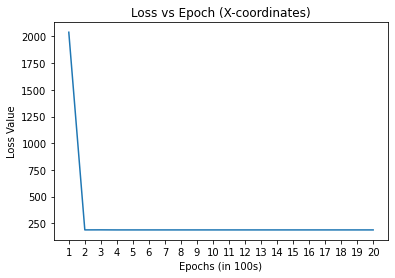

In [27]:
# Plot Epoch vs Loss for X coordinate data
plt.plot(np.arange(1, len(loss_vals_x)+1), loss_vals_x)
plt.xticks(np.arange(1, len(loss_vals_x)+1))
plt.xlabel("Epochs (in 100s)")
plt.ylabel("Loss Value")
plt.title("Loss vs Epoch (X-coordinates)")
plt.show()

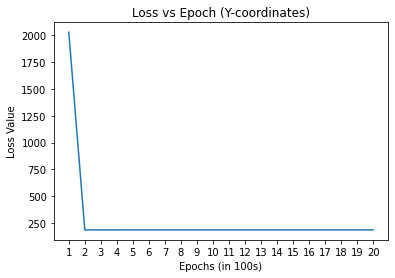

In [28]:
# Plot epoch vs Loss for Y coordinate data
plt.plot(np.arange(1, len(loss_vals_y)+1), loss_vals_y)
plt.xticks(np.arange(1, len(loss_vals_y)+1))
plt.xlabel("Epochs (in 100s)")
plt.ylabel("Loss Value")
plt.title("Loss vs Epoch (Y-coordinates)")
plt.show()